# 랜덤 포레스트 기법을 사용한 종목 흐름 예측

In [ ]:
!pip install -U finance-datareader


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import FinanceDataReader as fdr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


## 1. Data Preprocessing
 

#### 1.1 Default Features (from fdr)

In [ ]:
df = fdr.DataReader(symbol='005380', start='2012-01-01', end='2022-12-31')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2012-01-02,214000,215500,209500,212500,255312,-0.002347
2012-01-03,215000,222500,214500,221500,666913,0.042353
2012-01-04,224000,228000,222500,223500,584416,0.009029
2012-01-05,224500,228000,223000,223500,527310,0.000000
2012-01-06,224000,224500,215000,219500,542671,-0.017897
...,...,...,...,...,...,...
2022-12-23,157000,158000,155500,157000,336597,-0.009464
2022-12-26,157000,159000,157000,158000,387872,0.006369
2022-12-27,158500,160000,157000,158000,637139,0.000000


In [ ]:
current = fdr.DataReader(symbol='005380', start='2022-01-01', end='2023-01-01')
current


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-01-03,211500,212500,209000,210500,468732,0.007177
2022-01-04,212500,212500,208500,210000,499857,-0.002375
2022-01-05,214000,217500,212000,213500,1175411,0.016667
2022-01-06,210000,216500,210000,214000,866582,0.002342
2022-01-07,214500,216500,213500,215000,577852,0.004673
...,...,...,...,...,...,...
2022-12-23,157000,158000,155500,157000,336597,-0.009464
2022-12-26,157000,159000,157000,158000,387872,0.006369
2022-12-27,158500,160000,157000,158000,637139,0.000000


In [ ]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

#### 1.2 Extra Features Calculation


> 1 . RSI (Relative Strength Index)


Formula:

$RSI$ = ${100}$ - $\frac{100}{1+RS}$










In [ ]:
# 14 day RSI 
n = 14
up_df14, down_df14 = df[['Change']].copy(), df[['Change']].copy()
# For up days, if the change is less than 0 set to 0
# For down days, if the change is greater than 0 set to 0
up_df14.loc['Change'] = up_df14.loc[(up_df14['Change'] < 0), 'Change'] = 0
down_df14.loc['Change'] = down_df14.loc[(down_df14['Change']>0), 'Change'] = 0
au = up_df14.ewm(com = n-1, min_periods = n).mean()
ad = down_df14.abs().ewm(com = n-1, min_periods = n).mean()
RS = au/ad
RSI = 100 - (100/(1+RS))
df['RSI_14'] = RSI

In [ ]:
# 2 day RSI 
n = 5
up_df2, down_df2 = df[['Change']].copy(), df[['Change']].copy()
# For up days, if the change is less than 0 set to 0
# For down days, if the change is greater than 0 set to 0
up_df2.loc['Change'] = up_df2.loc[(up_df2['Change'] < 0), 'Change'] = 0
down_df2.loc['Change'] = down_df2.loc[(down_df2['Change']>0), 'Change'] = 0
au = up_df2.ewm(com = n-1, min_periods = n).mean()
ad = down_df2.abs().ewm(com = n-1, min_periods = n).mean()
RS = au/ad
RSI = 100 - (100/(1+RS))
df['RSI_5'] = RSI

In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Change,RSI_14,RSI_5
Date,,,,,,,,
2022-12-23,157000,158000,155500,157000,336597,-0.009464,37.449320,35.414268
2022-12-26,157000,159000,157000,158000,387872,0.006369,40.016663,43.012960
2022-12-27,158500,160000,157000,158000,637139,0.000000,40.016663,43.012960
2022-12-28,156000,156500,154000,154000,556921,-0.025316,33.650036,24.853271
2022-12-29,153000,154000,150500,151000,552974,-0.019481,29.730354,17.675514


2. Simple Moving Average (SMA)

3-4 Intervals? (Short, Middle, Long-term)

In [ ]:
df['SMA_20'] = df['Close'].rolling(window = 20).mean()
df['SMA_60'] = df['Close'].rolling(window = 60).mean()
df['SMA_120'] = df['Close'].rolling(window = 120).mean()
df.tail()

,Open,High,Low,Close,Volume,Change,RSI_14,RSI_5,SMA_20,SMA_60,SMA_120
Date,,,,,,,,,,,
2022-12-23,157000,158000,155500,157000,336597,-0.009464,37.449320,35.414268,163100.0,166850.000000,179083.333333
2022-12-26,157000,159000,157000,158000,387872,0.006369,40.016663,43.012960,162625.0,166458.333333,178916.666667
2022-12-27,158500,160000,157000,158000,637139,0.000000,40.016663,43.012960,162075.0,166150.000000,178754.166667
2022-12-28,156000,156500,154000,154000,556921,-0.025316,33.650036,24.853271,161325.0,165725.000000,178600.000000
2022-12-29,153000,154000,150500,151000,552974,-0.019481,29.730354,17.675514,160300.0,165291.666667,178400.000000


3. Williams %R

In [ ]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = df['Low'].copy(), df['High'].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.rolling(window = n).min()
high_14 = high_14.rolling(window = n).max()

# Calculate William %R indicator.
r_percent = ((high_14 - df['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
df['r_percent'] = r_percent
df

,Open,High,Low,Close,Volume,Change,RSI_14,RSI_5,SMA_20,SMA_60,SMA_120,r_percent
Date,,,,,,,,,,,,
2012-01-02,214000,215500,209500,212500,255312,-0.002347,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,215000,222500,214500,221500,666913,0.042353,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,224000,228000,222500,223500,584416,0.009029,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,224500,228000,223000,223500,527310,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,224000,224500,215000,219500,542671,-0.017897,NaN,59.288111,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,157000,158000,155500,157000,336597,-0.009464,37.449320,35.414268,163100.0,166850.000000,179083.333333,-76.190476
2022-12-26,157000,159000,157000,158000,387872,0.006369,40.016663,43.012960,162625.0,166458.333333,178916.666667,-66.666667
2022-12-27,158500,160000,157000,158000,637139,0.000000,40.016663,43.012960,162075.0,166150.000000,178754.166667,-66.666667


**Chart of Hyundai Motors**

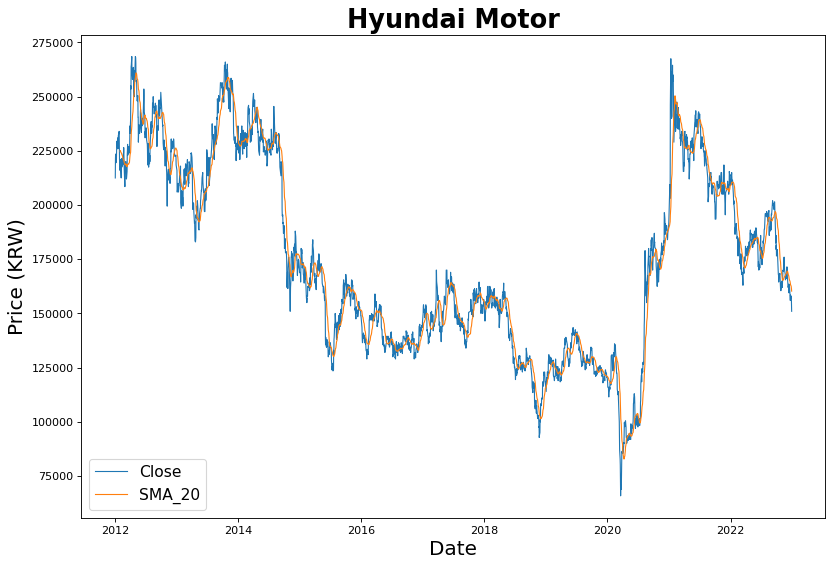

In [ ]:
plt.figure(figsize=(12, 8), dpi=80)

#palette = sns.color_palette("hls", 4)
#sns.set_palette(palette)
#sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')

vars = ['Close', 'SMA_20']
for i in vars:
    plt.plot(df.index, df[i], label = i, linewidth = 1)

date_form = DateFormatter("%Y")
plt.gca().xaxis.set_major_formatter(date_form)

plt.legend(fontsize = 14, loc = 'lower left')
plt.title("Hyundai Motor", fontsize = 23, weight = 'bold')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Price (KRW)', fontsize = 18)
plt.show()


**ADD PREDICTION COLUMN**

In [ ]:
# Grab the Close Column
close_groups = df['Close']

# Apply the lambda function to return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))
df['Prediction'] = close_groups

# To keep prediction a binary classifier -- convert 0.0 no change to 1.0
df.loc[df['Prediction'] == 0.0, 'Prediction'] = 1.0
df

,Open,High,Low,Close,Volume,Change,RSI_14,RSI_5,SMA_20,SMA_60,SMA_120,r_percent,Prediction
Date,,,,,,,,,,,,,
2012-01-02,214000,215500,209500,212500,255312,-0.002347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,215000,222500,214500,221500,666913,0.042353,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2012-01-04,224000,228000,222500,223500,584416,0.009029,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2012-01-05,224500,228000,223000,223500,527310,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2012-01-06,224000,224500,215000,219500,542671,-0.017897,NaN,59.288111,NaN,NaN,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,157000,158000,155500,157000,336597,-0.009464,37.449320,35.414268,163100.0,166850.000000,179083.333333,-76.190476,-1.0
2022-12-26,157000,159000,157000,158000,387872,0.006369,40.016663,43.012960,162625.0,166458.333333,178916.666667,-66.666667,1.0
2022-12-27,158500,160000,157000,158000,637139,0.000000,40.016663,43.012960,162075.0,166150.000000,178754.166667,-66.666667,1.0


In [ ]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))

# Any row that has a `NaN` value will be dropped.
df = df.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))

# Print the df.
df

Before NaN Drop we have 2709 rows and 13 columns
After NaN Drop we have 2590 rows and 13 columns


,Open,High,Low,Close,Volume,Change,RSI_14,RSI_5,SMA_20,SMA_60,SMA_120,r_percent,Prediction
Date,,,,,,,,,,,,,
2012-06-26,240000,241000,237000,238500,292563,-0.010373,45.395795,31.754021,241500.0,248558.333333,235129.166667,-83.720930,-1.0
2012-06-27,238000,238500,228000,231000,1072171,-0.031447,38.595735,20.064365,241175.0,248466.666667,235283.333333,-89.473684,-1.0
2012-06-28,232500,235000,229500,234000,462154,0.012987,42.431095,32.829564,240725.0,248483.333333,235387.500000,-78.947368,1.0
2012-06-29,229000,233000,226500,232500,933968,-0.006410,41.067587,29.885027,240150.0,248358.333333,235462.500000,-80.000000,-1.0
2012-07-02,236500,237500,234500,235500,438405,0.012903,44.905451,42.794840,240025.0,248033.333333,235562.500000,-70.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,157000,158000,155500,157000,336597,-0.009464,37.449320,35.414268,163100.0,166850.000000,179083.333333,-76.190476,-1.0
2022-12-26,157000,159000,157000,158000,387872,0.006369,40.016663,43.012960,162625.0,166458.333333,178916.666667,-66.666667,1.0
2022-12-27,158500,160000,157000,158000,637139,0.000000,40.016663,43.012960,162075.0,166150.000000,178754.166667,-66.666667,1.0


**SPLIT TRAINING DATA AND TEST DATA**

In [ ]:
# Select X & Y Columns. (X = Features, Y = Predictions)
X_Cols = df[['Close', 'Volume', 'RSI_14', 'RSI_5', 'SMA_20', 'SMA_120','SMA_60', 'r_percent']]
Y_Cols = df['Prediction']

# Split Dataset into Training and Test set (8:2)
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, test_size=0.2, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, max_leaf_nodes= 40, max_features= 8, 
                                       oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [ ]:
print("accuracy_score of train data(0.8 of sample): ", rand_frst_clf.score(X_train, y_train))
print("accuracy_score of test data(0.2 of sample): ", rand_frst_clf.score(X_test, y_test))


accuracy_score of train data(0.8 of sample):  0.8083976833976834
accuracy_score of test data(0.2 of sample):  0.7432432432432432


In [ ]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  74.32432432432432


In [ ]:
# Define the target names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.713656,0.704348,0.708972,230.000000
Up Day,0.766323,0.774306,0.770294,288.000000
accuracy,0.743243,0.743243,0.743243,0.743243
macro avg,0.739990,0.739327,0.739633,518.000000
weighted avg,0.742938,0.743243,0.743066,518.000000


Accuracy: 0.7432432432432432
Percision: 0.7663230240549829
Recall: 0.7743055555555556
Specificity: 0.7043478260869566


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


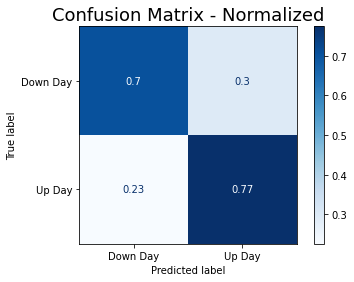

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized', size = 18)
plt.show()

<AxesSubplot:>

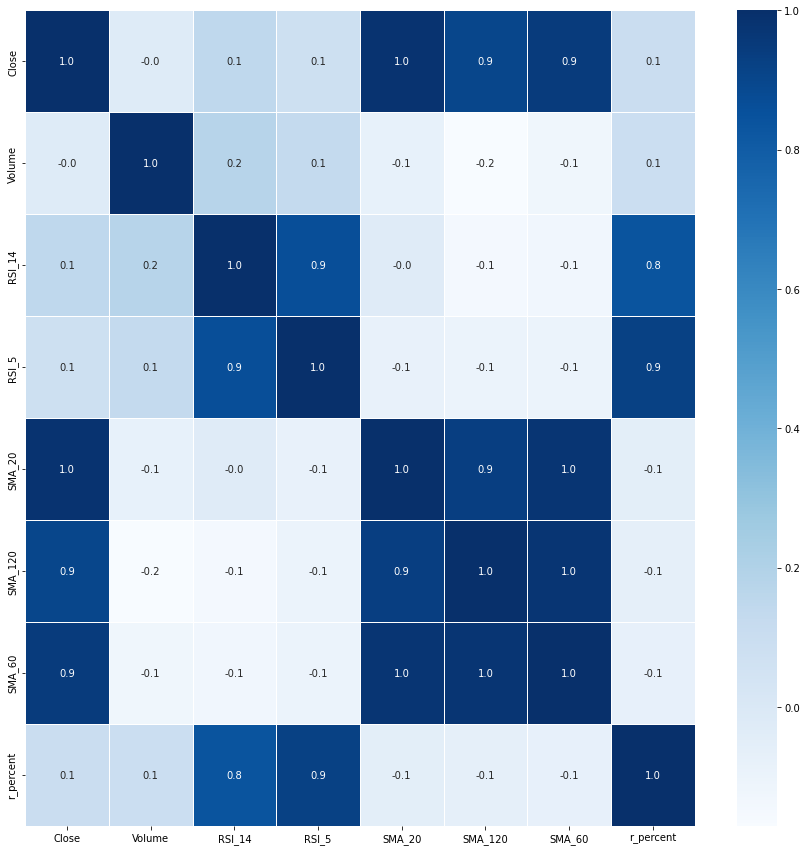

In [ ]:
X_Cols.corr()
plt.figure(figsize=(15,15))
sns.heatmap(data = X_Cols.corr(), annot=True, 
fmt = '.1f', linewidths=.5, cmap='Blues')

In [ ]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

RSI_5        0.502654
r_percent    0.228374
RSI_14       0.104070
Volume       0.068110
SMA_120      0.033243
SMA_60       0.023756
SMA_20       0.022272
Close        0.017521
dtype: float64

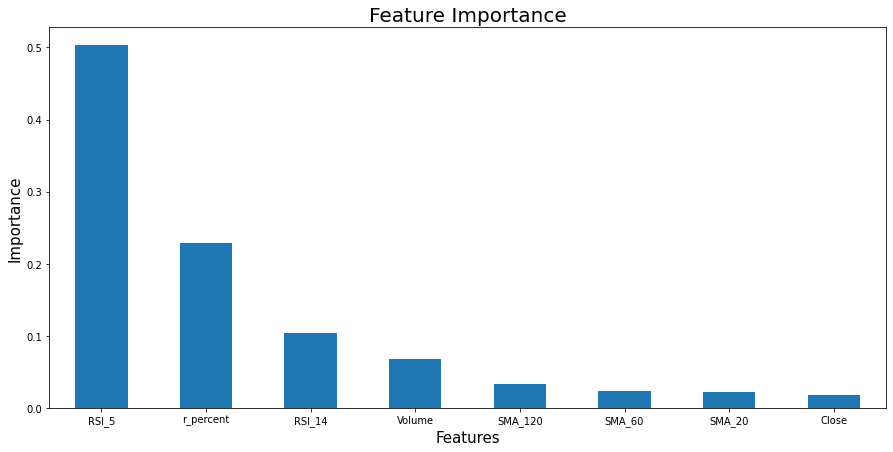

In [ ]:
# Plot the bar chart to visualize the feature importance
plt.figure(figsize=(15,7))
feature_imp.plot(kind="bar", title="Feature Importance")
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Feature Importance", size = 20)
plt.xlabel("Features", size = 15)
plt.ylabel("Importance", size = 15)
plt.show()

In [ ]:

print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.7268339768339769


In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Change,RSI_14,RSI_5,SMA_20,SMA_60,SMA_120,r_percent,Prediction
Date,,,,,,,,,,,,,
2022-12-23,157000,158000,155500,157000,336597,-0.009464,37.449320,35.414268,163100.0,166850.000000,179083.333333,-76.190476,-1.0
2022-12-26,157000,159000,157000,158000,387872,0.006369,40.016663,43.012960,162625.0,166458.333333,178916.666667,-66.666667,1.0
2022-12-27,158500,160000,157000,158000,637139,0.000000,40.016663,43.012960,162075.0,166150.000000,178754.166667,-66.666667,1.0
2022-12-28,156000,156500,154000,154000,556921,-0.025316,33.650036,24.853271,161325.0,165725.000000,178600.000000,-100.000000,-1.0
2022-12-29,153000,154000,150500,151000,552974,-0.019481,29.730354,17.675514,160300.0,165291.666667,178400.000000,-96.551724,-1.0


In [ ]:
prob = rand_frst_clf.predict_proba(X_test)
prob_df = pd.DataFrame(prob, index=y_test.index)
prob_df

,0,1
Date,,
2022-03-30,0.085084,0.914916
2015-10-12,0.596364,0.403636
2022-10-04,0.486975,0.513025
2014-04-09,0.871457,0.128543
2020-01-15,0.276970,0.723030
...,...,...
2021-10-22,0.769792,0.230208
2012-12-24,0.766912,0.233088
2018-03-30,0.940057,0.059943


In [ ]:
prob_2022 = prob_df['2022']

<ipython-input-90-1fa5ad6d6b63>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  prob_2022 = prob_df['2022']


In [ ]:
prob_2022

,0,1
Date,,
2022-03-30,0.085084,0.914916
2022-10-04,0.486975,0.513025
2022-11-10,0.154233,0.845767
2022-10-17,0.559057,0.440943
2022-11-03,0.619783,0.380217
...,...,...
2022-06-28,0.132615,0.867385
2022-11-07,0.156738,0.843262
2022-03-10,0.327497,0.672503


In [ ]:
prob_2022['result'] = prob_2022[0] > prob_2022[1]
prob_2022['result'] = prob_2022['result'].replace({False:1.0, True:-1.0}) 
prob_2022

,0,1,result
Date,,,
2022-03-30,0.085084,0.914916,1.0
2022-10-04,0.486975,0.513025,1.0
2022-11-10,0.154233,0.845767,1.0
2022-10-17,0.559057,0.440943,-1.0
2022-11-03,0.619783,0.380217,-1.0
...,...,...,...
2022-06-28,0.132615,0.867385,1.0
2022-11-07,0.156738,0.843262,1.0
2022-03-10,0.327497,0.672503,1.0


In [ ]:
prob_2022= prob_2022.sort_values(by=['Date'], axis=0)


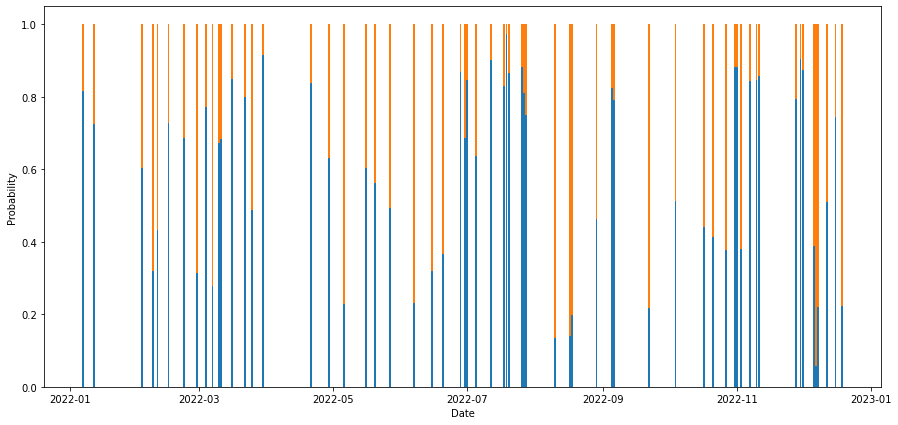

In [ ]:
plt.figure(figsize=(15,7))
inc = prob_2022[1]
dec = prob_2022[0]
plt.bar(prob_2022.index, inc)
plt.bar(prob_2022.index, dec, bottom=inc)
plt.xlabel("Date")
plt.ylabel("Probability")
plt.show()

In [ ]:
dfh = fdr.DataReader(symbol='005380', start='2022-01-01', end='2022-12-31')
dfh

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-01-03,211500,212500,209000,210500,468732,0.007177
2022-01-04,212500,212500,208500,210000,499857,-0.002375
2022-01-05,214000,217500,212000,213500,1175411,0.016667
2022-01-06,210000,216500,210000,214000,866582,0.002342
2022-01-07,214500,216500,213500,215000,577852,0.004673
...,...,...,...,...,...,...
2022-12-23,157000,158000,155500,157000,336597,-0.009464
2022-12-26,157000,159000,157000,158000,387872,0.006369
2022-12-27,158500,160000,157000,158000,637139,0.000000


In [ ]:
# Grab the Close Column
close = dfh['Close']

# Apply the lambda function to return -1.0 for down, 1.0 for up and 0.0 for no change.
close = close.transform(lambda x : np.sign(x.diff()))
dfh['Prediction'] = close
dfh.loc[dfh['Prediction'] == 0.0, 'Prediction'] = 1.0
dfh

,Open,High,Low,Close,Volume,Change,Prediction
Date,,,,,,,
2022-01-03,211500,212500,209000,210500,468732,0.007177,NaN
2022-01-04,212500,212500,208500,210000,499857,-0.002375,-1.0
2022-01-05,214000,217500,212000,213500,1175411,0.016667,1.0
2022-01-06,210000,216500,210000,214000,866582,0.002342,1.0
2022-01-07,214500,216500,213500,215000,577852,0.004673,1.0
...,...,...,...,...,...,...,...
2022-12-23,157000,158000,155500,157000,336597,-0.009464,-1.0
2022-12-26,157000,159000,157000,158000,387872,0.006369,1.0
2022-12-27,158500,160000,157000,158000,637139,0.000000,1.0


In [ ]:
df1 = dfh['Prediction']

In [ ]:
prob_2022= prob_2022.sort_values(by=['Date'], axis=0)
df2 = prob_2022['result']

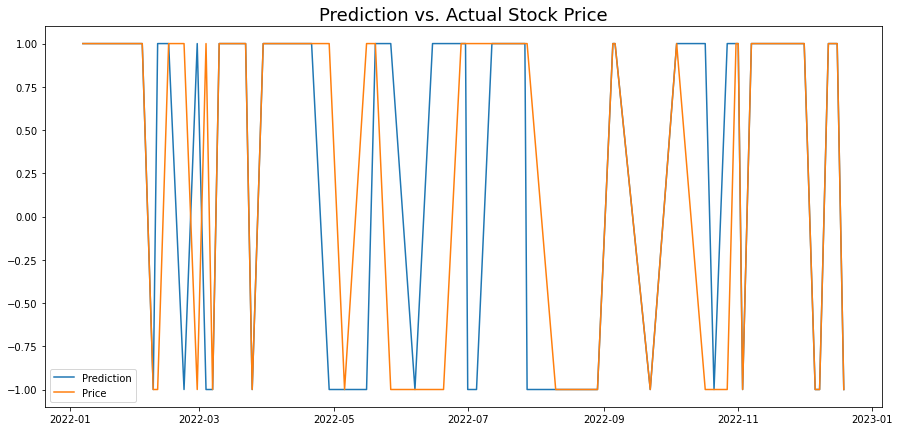

In [ ]:
result = pd.concat([df1,df2],axis=1)
result = result.dropna()
plt.figure(figsize=(15,7))
plt.title("Prediction vs. Actual Stock Price", size = 18)
plt.plot(result['Prediction'], label = 'Prediction')
plt.plot(result['result'], label = 'Price')
plt.legend()
plt.show()

In [ ]:
result['compare'] = result['Prediction'] == result['result']
result

cal = len(result.loc[result['compare'] == True])/len(result['compare'])
cal

0.7741935483870968